# TIME SERIES FORECASTING TUTORIAL
## USING MACHINE LEARNING TO FORECAST ENERGY CONSUMPTION
Source: https://www.youtube.com/watch?v=vV12dGe_Fho

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('./data_raw/AEP_hourly.csv')
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB
None
             Datetime   AEP_MW
0 2004-12-31 01:00:00  13478.0
1 2004-12-31 02:00:00  12865.0
2 2004-12-31 03:00:00  12577.0
3 2004-12-31 04:00:00  12517.0
4 2004-12-31 05:00:00  12670.0


In [4]:
df = df.set_index('Datetime')

<AxesSubplot: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

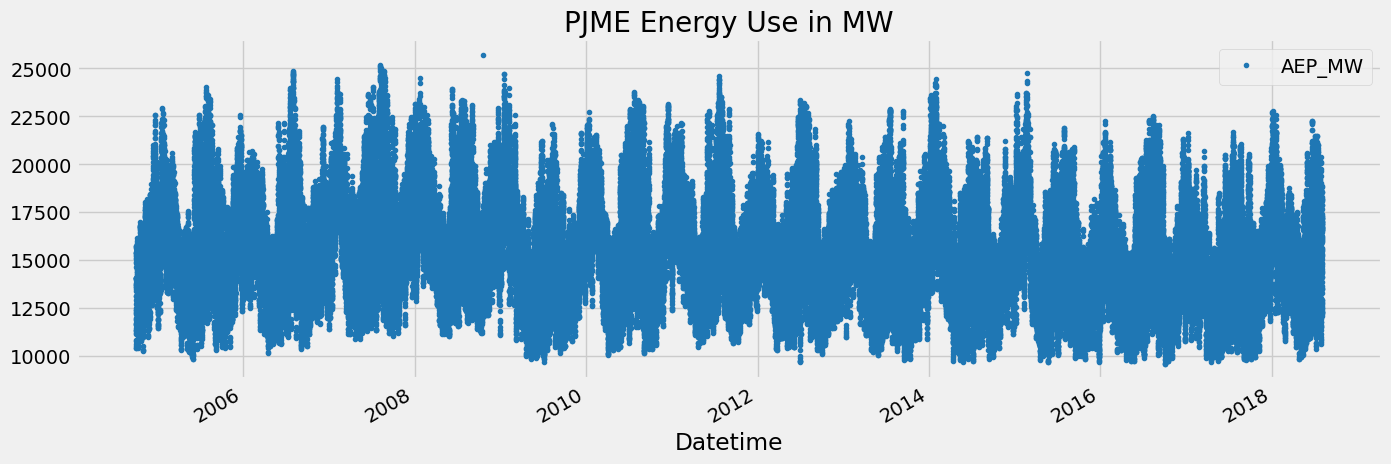

In [5]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME Energy Use in MW')

# Train/ Test Split

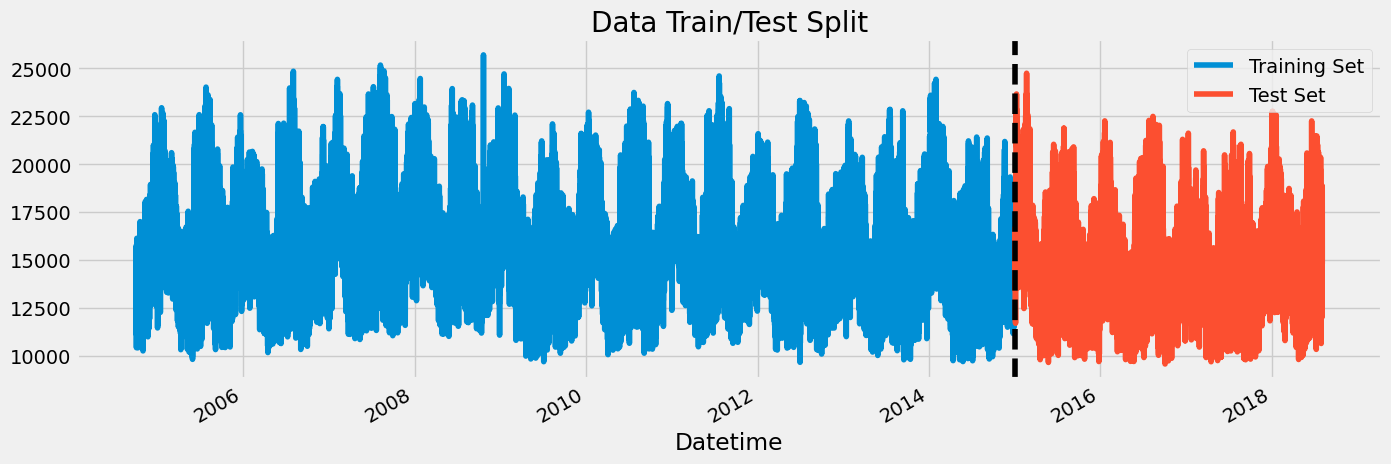

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

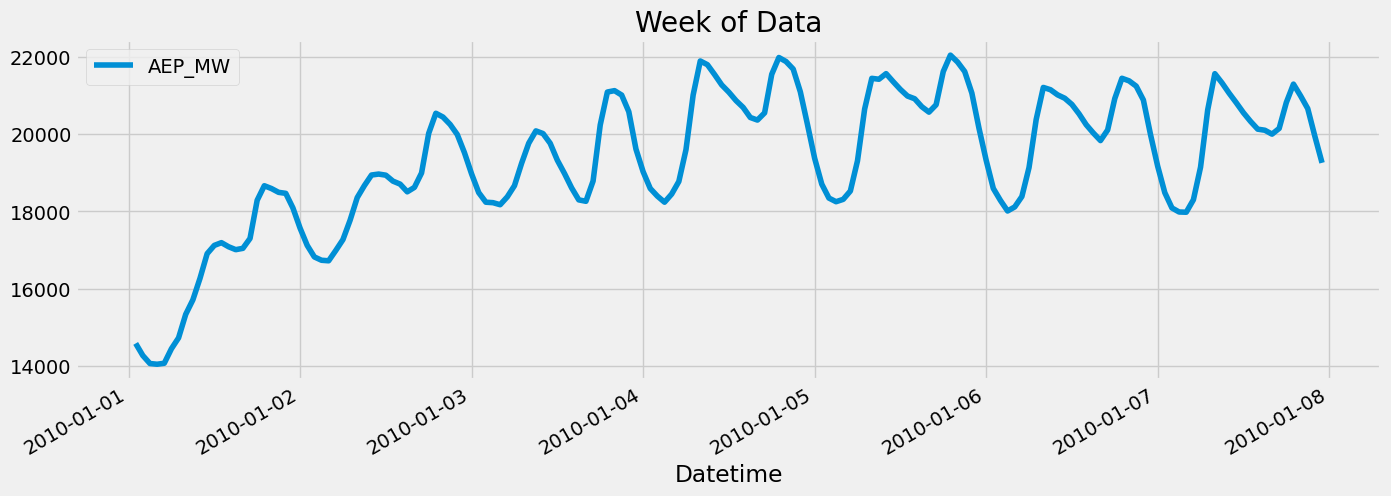

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
plt.show()

# Feature Creation

In [8]:
def create_features(df):
    """
    Create time series feature based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [9]:
df = create_features(df)

# Visualize our Feature / Target Relationship

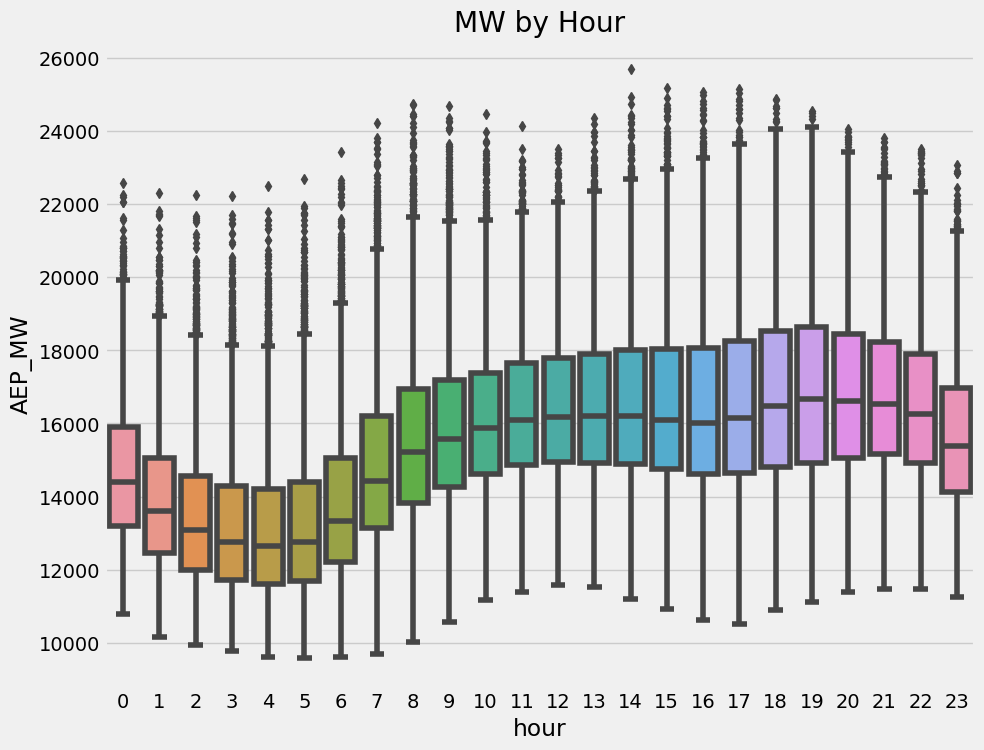

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

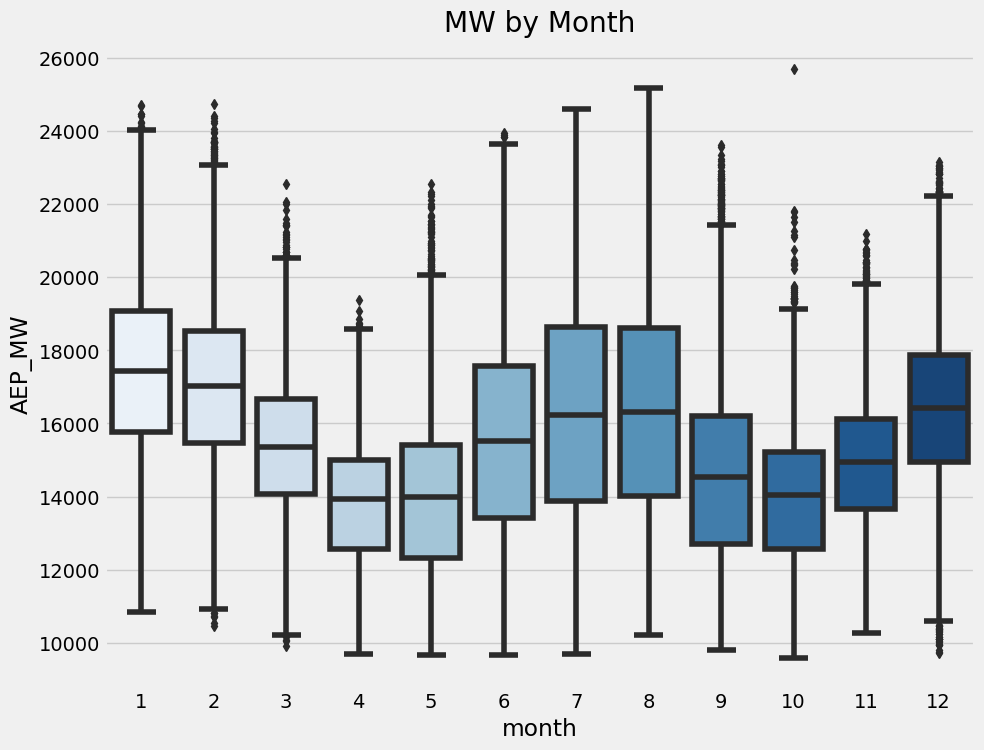

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [12]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [13]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                        learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.73720	validation_1-rmse:5178.62380
[200]	validation_0-rmse:2508.53193	validation_1-rmse:2123.13253
[300]	validation_0-rmse:1473.01351	validation_1-rmse:1575.81274
[384]	validation_0-rmse:1225.32597	validation_1-rmse:1578.11767


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# Feature Importance

In [19]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Importance'])

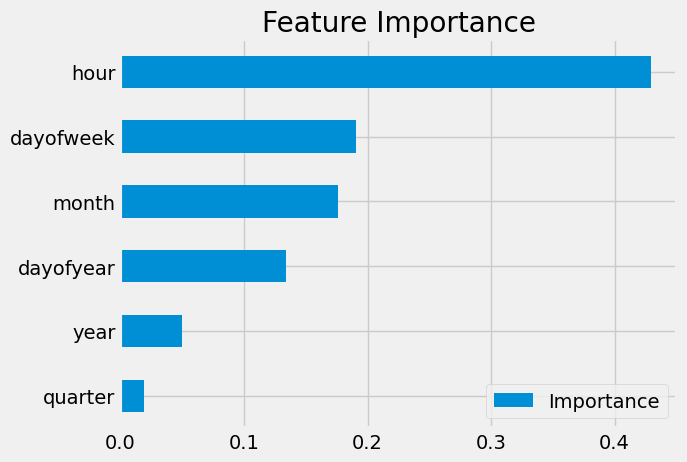

In [22]:
fi.sort_values('Importance').plot(kind ='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


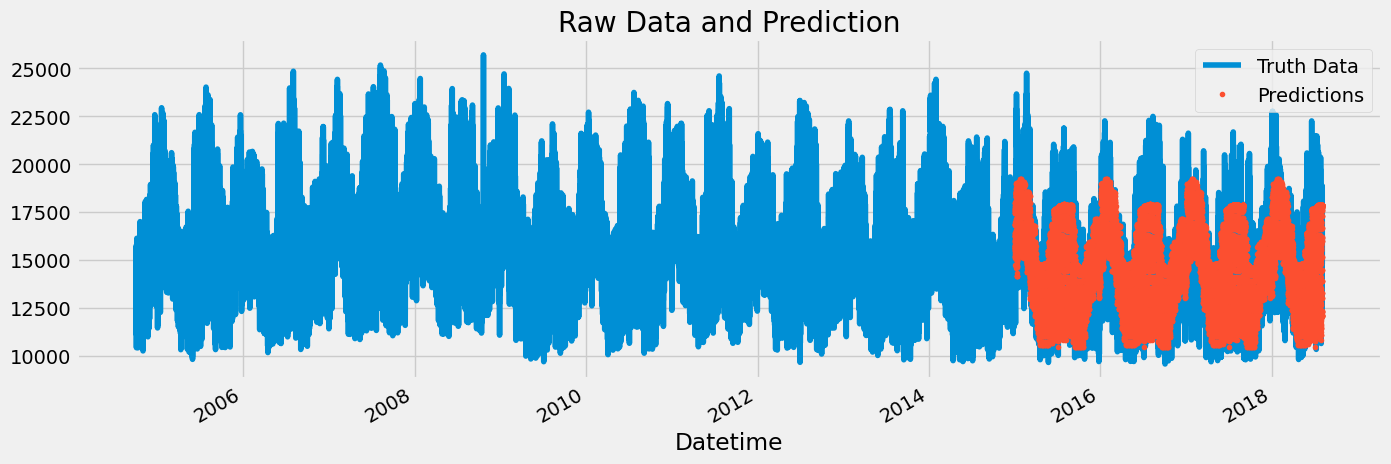

In [27]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

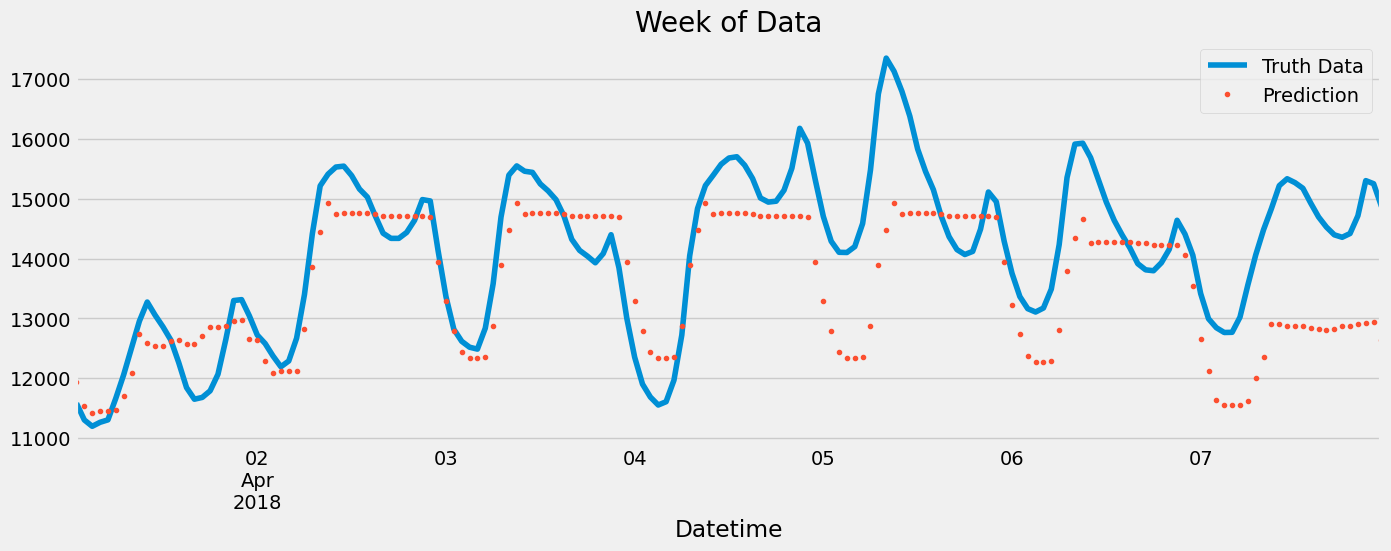

In [31]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15,5), title= 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

* There is a lot of improvement that we could make
* We could have a better hyperparameter tunning (we didn't tune this model) 
* Add features for specific days (e.g. hollidays)

In [38]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 1561.92


# Calculate Error
* Look at the worst and best predicted days

In [41]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [42]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-20    5440.931478
2015-02-19    5334.938965
2018-01-06    5122.144572
2018-01-07    4750.093465
2015-02-16    4289.385946
Name: error, dtype: float64

In [44]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2017-05-21    204.458089
2015-09-26    204.753052
2017-11-16    215.657267
2017-10-12    219.098796
2015-09-30    225.333293
Name: error, dtype: float64

# Next Steps
- More robust cross Validation
- Add more features (weather forecast, holidays)